# Code for analyzing the behavioral data from the associative boosting task

In [1]:
import os
import numpy as np
import glob
import csv
import matplotlib
import glob
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame, Series
import seaborn as sns
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
import scipy
import patsy
import ast
%matplotlib inline

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
home_dir = os.path.abspath('../') #where the data live
data_dir = home_dir + '/data/associative_boost/'
print data_dir

/Users/ianballard/Dropbox/two_step_analysis/data/associative_boost/


# Load and clean data

In [3]:
ignore_files = []
data_files = glob.glob(data_dir + '*txt')
data_files = [d for d in data_files if d.split('/')[-1] not in ignore_files]
sub_ids = map(lambda f: f.split('/')[-1].split('.csv')[0],data_files)
print(len(data_files))

43


In [4]:
def fixup(sub_data,d):
    if d in sub_data:
        col = sub_data[d].dropna()     
        sub_data[d] = col.values[0]    
    return sub_data

In [40]:
all_data = []
for i,f in enumerate(data_files):
    sub_data = []
    with open(f, 'r') as myfile:
        data = myfile.read() 
    d = data.split('\n')[:-1]
    for line in d:
        try:
            line = line.replace('null','-1') #ast doesnt like null objects
            line = ast.literal_eval(line)
            line = {key:str(val) for key, val in line.iteritems()}
            line = pd.DataFrame(line, index=[0])
            sub_data.append(line)
        except:
            print i,line
    sub_data = pd.concat(sub_data).reset_index()
    sub_data['sub'] = f.split('/')[-1].split('.')[0]
    
    #clean up demongraphic info
    demographic = ['age','cig','drg','eth','his','oth','numPieces','number','text']
    for d in demographic:
        sub_data = fixup(sub_data,d)
    sub_data = sub_data.drop('index', 1)
    
    all_data.append(sub_data)

In [41]:
all_data = pd.concat(all_data)
all_data = all_data.reset_index()

In [7]:
subs = list(set(all_data['sub']))

In [45]:
bad_subs = []
for s in subs:
    sub_df = all_data[all_data['sub'] == s]
    if len(set(sub_df['loopNumber'].values)) != 4: #3 loops plus NaN
        bad_subs.append(s)
    if sub_df[sub_df['name'] == 'twoStep'].shape[0] < 145:
        bad_subs.append(s)
    
for s in bad_subs:
    all_data = all_data[all_data['sub'] != s]
subs = list(set(all_data['sub']))
print len(subs)

24


# Analyze two step data for transition/reward interaction

In [59]:
two_step = []
for s in subs:
    sub_df = all_data[all_data['sub'] == s]
    ts = sub_df[sub_df['name'] == 'twoStep'].copy()
    ts = ts[ts['reward'] != '-1'] #drop missed responses
    
    #block number
    trial_num = ts['trialNum'].values
    starts = np.where(trial_num == '0')[0]
    block = []
    for n,i in enumerate(starts):
        if n < len(starts)-1:
            b = np.zeros(starts[n+1] - i) + n
        else:
            b = np.zeros(len(trial_num) - i) + n
        block.extend(b)
    ts['block'] = block

    #choice 1 (shifted)
    choice_map = {'left':0,'right':1}
    choice1 = [ast.literal_eval(x)['1'] for x in ts['response'].values]
    choice1 = [choice_map[x] for x in choice1]

    stay_indicator = [np.NaN]
    for n,c in enumerate(choice1):
        if n>0:
            if c == choice1[n-1]:
                stay_indicator.append('stay')
            else:
                stay_indicator.append('switch')
    choice1.append(np.NaN)
    choice1 = choice1[1:]
    ts['choice1'] = choice1
    ts['stay'] = stay_indicator

    #trial type
    stage2 = [ast.literal_eval(x).keys()[1] for x in ts['response'].values]
    ttype = []
    for choice,stage in zip(choice1,stage2):
        if (choice == 0 and stage == '2a') or (choice == 1 and stage == '2b'):
            ttype.append('common')
        else:
            ttype.append('rare')
    ts['ttype'] = ttype

    ts = ts[['ttype','reward','choice1','stay','sub','block']]
    ts = ts.dropna()
    two_step.append(ts)
two_step = pd.concat(two_step)

In [60]:
#normalize regressors
stay_map = {'switch':-1,'stay':1}
trans_map = {'common':1,'rare':-1}
two_step['ttype_bin'] = map(lambda x: trans_map[x],two_step['ttype'])
two_step['stay_bin'] = map(lambda x: stay_map[x],two_step['stay'])
two_step['reward'] = 2*(np.array(map(float,two_step['reward'])) - .5)
# two_step['correct'] = all_data['correct'] - .5


In [117]:
#logistic regression analysis
ttype_betas = []
stay_betas = []
rew_betas = []
intercept_betas = []
interaction_betas = []
# correct_betas = []
score = []

      
for n,sub in enumerate(subs):
    sub_data = two_step[two_step['sub'] == sub] 

    y, X = dmatrices('stay_bin ~ ttype_bin + reward + reward:ttype_bin + C(block)',
                 sub_data,return_type="dataframe")

    y = np.ravel(y)
    model = LogisticRegression()
    model = model.fit(X, y)
    betas = pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))
    coef = model.coef_[0]
    if len(coef) == 6:
        score.append(model.score(X, y))
        intercept_betas.append(coef[0])
        ttype_betas.append(coef[3])
        rew_betas.append(coef[4])
        interaction_betas.append(coef[5])

In [123]:
no_inter_subs = []
for s,rew,inter,sc in zip(subs,rew_betas,interaction_betas,score):
    if inter < 0 or rew < 0:
        no_inter_subs.append(s)
    else:
        print sc
print no_inter_subs
print interaction_betas
print rew_betas

0.880794701987
0.610738255034
0.754966887417
0.841059602649
0.867549668874
0.854304635762
0.615894039735
['A1T6RFUU0OTS0M', 'A2CF2BD4Q0ZDJN', 'A3OYUJ6E6BJS4H', 'A2OO4PG3LBLP5I', 'A2UYNLN1B4JV8Y', 'AFEJL4G9L6XN7', 'A1SLJKNSNHOJRN', 'A28F1ZWZ9H0RHA', 'A3RHGIM99R25Q9', 'A2JJRPI671MF0U', 'A6P0CC8HHZLFJ', 'AS7WV8YWOEO55', 'A2YKW761AK4ZGY', 'A18U9WMYFYJPR6', 'AFXE92S04IYHY', 'A3B7TNVOISSZ2O']
[-0.047462249007395617, 0.14172164909390883, 0.33203062161682162, 0.25158364412436152, 0.33049313920921336, 0.037988698752173158, 0.33082290975458684, 0.014523221401805333, 0.034313435103291913, 0.20633716463556023, -0.063910915514898983, -0.10585549234668544, 0.21297893899926931, 0.25318622398598906, 0.033924941378636539, 0.10436261715327294, 0.4377805245113196, 0.11286696679137791, -0.098760244656364321, 0.1583888457103694, -0.17342526201356825, -0.00061560275378196624, -0.31880862825881789]
[-0.12047757557991201, -0.0019498965164847345, -0.18052311234887417, -0.43563173392480298, 0.099249612940962309

In [68]:
t,p = scipy.stats.ttest_1samp(ttype_betas,0)
print 'ttype',t,p

t,p = scipy.stats.ttest_1samp(intercept_betas,0)
print 'intercept',t,p

t,p = scipy.stats.ttest_1samp(rew_betas,0)
print 'rew',t,p

t,p = scipy.stats.ttest_1samp(interaction_betas,0)
print 'interaction',t,p

t,p = scipy.stats.ttest_1samp(score,.5)
print 'score',np.mean(score),t,p

ttype 0.110672246489 0.912879692466
intercept 6.11488330984 3.73096271492e-06
rew -0.0319306434176 0.974815280658
interaction 2.45031775829 0.0226921106443
score 0.761471355148 11.4313953676 1.00398943285e-10


# Analyze neutral trials

In [124]:
def get_prop_targ(pre_post,block_df):
    pre = block_df[block_df['pre_post'] == pre_post]
    num_targ = np.sum(pre['target_indicator'])
    num_choice_targ = np.sum(pre['choice'] == 'tgt')
    prop_targ = num_choice_targ *1.0 / num_targ
    return prop_targ

In [127]:
neutral_choice = {'sub':[],'block':[],'pre_post':[],'prop':[]}
for s in subs:
    if s not in no_inter_subs:
        sub_df = all_data[all_data['sub'] == s]
        neutral = sub_df[sub_df['name'] == 'neutral'].copy()

        ##parse out the block and the run numbers from the neutral trial numbers [0 to 9]
        trial_num = neutral['trialNum'].values
        neutral_starts = np.where(trial_num == '0')[0]
        neutral_run = []
        for n,i in enumerate(neutral_starts):
            if n < len(neutral_starts)-1:
                block = np.zeros(neutral_starts[n+1] - i) + n
            else:
                block = np.zeros(len(trial_num) - i) + n
            neutral_run.extend(block)
        neutral_run = map(int,neutral_run)
        neutral['run'] = neutral_run

        block_map = {0:0,1:0,2:1,3:1,4:2,5:2}
        neutral['block'] = [block_map[x] for x in neutral_run]

        prepost_map = {0:'pre',1:'post',2:'pre',3:'post',4:'pre',5:'post'}
        neutral['pre_post'] = [prepost_map[x] for x in neutral_run]

        #filter missed responses
        fb = [ast.literal_eval(x).keys()[1] for x in neutral['stageOnsetTime'].values]
        neutral['too_slow'] = [x!='tooslow' for x in fb]
        neutral = neutral[neutral['too_slow'] == True]

        #parse the choices
        choice_map = {'left':0,'right':1}
        choices = [ast.literal_eval(x)['1'] for x in neutral['response'].values]
        choices = [choice_map[x] for x in choices]
        neutral['response'] = choices

        #parse the stimuli
        stims = [ast.literal_eval(x) for x in neutral['stimuli'].values]
        which_choice = [stim[choice] for stim,choice in zip(stims,choices)]
        target_indicator = ['tgt' in x for x in stims]
        neutral['target_indicator'] = target_indicator
        neutral['choice'] = which_choice

        #reaction time
        respT = np.array([ast.literal_eval(x)['1'] for x in neutral['responseTime'].values])
        onsetT = np.array([ast.literal_eval(x)['1'] for x in neutral['stageOnsetTime'].values])
        neutral['RT'] = respT - onsetT

        # neutral
        for block in range(3):
            block_df = neutral[neutral['block'] == block]
            for pp in ['pre','post']:
                prop_targ = get_prop_targ(pp,block_df)
                neutral_choice['sub'].append(s)
                neutral_choice['prop'].append(prop_targ)
                neutral_choice['pre_post'].append(pp)
                neutral_choice['block'].append(block)
neutral_choice = pd.DataFrame(neutral_choice)

In [128]:
neutral_choice = neutral_choice[neutral_choice['block'] ==0]
prop_diff = neutral_choice[neutral_choice['pre_post'] == 'post']['prop'].values \
    - neutral_choice[neutral_choice['pre_post'] == 'pre']['prop'].values
neutral_choice = neutral_choice.groupby(['sub','block']).mean()
neutral_choice.reset_index(inplace=True)  
neutral_choice['prop'] = prop_diff
neutral_choice.groupby('sub').mean()


,block,prop
sub,,
A142ZRU284W9O,0,-0.25
A1A3TGZ7DKJWRW,0,-0.25
A1C0H8G0YI15MN,0,0.00
A2TZJKKUN0LSHY,0,0.25
A3LZCR1FDVSVQ8,0,0.25
A3QJJR5Y3XE92N,0,0.00
AM8OWAW9TUVLN,0,-0.25
AXJSZ1BBVYIYL,0,-0.50


(array([ 1.,  0.,  0.,  3.,  0.,  0.,  2.,  0.,  0.,  2.]),
 array([-0.5  , -0.425, -0.35 , -0.275, -0.2  , -0.125, -0.05 ,  0.025,
         0.1  ,  0.175,  0.25 ]),
 <a list of 10 Patch objects>)

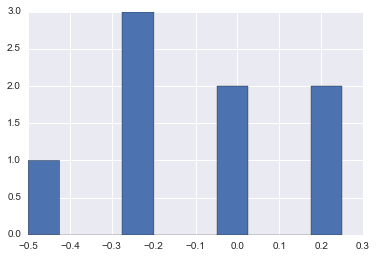

In [129]:
plt.hist(prop_diff)

In [131]:
prop_diff

array([-0.25, -0.25,  0.  ,  0.25,  0.25,  0.  , -0.25, -0.5 ])

In [67]:
# #calculate bonus for each subject (bonuses)
all_data['reward'] = map(float,all_data['reward'])
rew_data = all_data[['reward','id']].copy().dropna()
bonuses = all_data.groupby(['id']).sum().dropna()['reward']* .02
bonuses = bonuses.reset_index() 

bonuses['Assignment'] = np.NaN
worker_data = pd.read_csv('../transaction_data/Transactions_2016-05-01_to_2016-06-03.csv')
for sub in bonuses['id']:
    assignment_id = worker_data[worker_data['Recipient ID'] == sub]['Assignment ID']
    if len(assignment_id) > 0:
        assignment_id = np.array(assignment_id)[0]
        bonuses.ix[bonuses['id'] == sub,'Assignment'] = assignment_id
    else:
        print sub
bonuses = bonuses.dropna()
bonuses = bonuses.drop_duplicates()
bonuses.to_csv('../transaction_data/payment2.txt',columns = ['Assignment','id','reward'],header = False, index = False)

# payments = pd.read_csv(home_dir + '/transaction_data/logs_for_tamara_3_30.csv')
# payments = payments.sort('Transaction Type')
# payments.to_csv(home_dir + '/transaction_data/logs_for_tamara_3_30_sorted.csv')
# print payments.groupby('Transaction Type').sum()

A1LAZ3AO0NYBC1
A3N0QZ9ZKUCTCQ
A3P5WIW36V70AI
                id  reward                      Assignment
0   A13UK1HPOJZVRO    0.58  3IJXV6UZ1XJFEMS4X0W5V4BDK0QIRE
1   A13VIJ7G997ZCY    0.54  3OHYZ19UGC5XBRHQTKNOKBIPW4XAON
2    A142ZRU284W9O    1.84  3T3IWE1XG6N5BZTFEX694L3H05ATQW
3   A18U9WMYFYJPR6    2.06  33F859I566DS2K0VVLSUVD5U3BABHO
4   A1A3TGZ7DKJWRW    2.18  3PDJHANYK5GMW8J0ZUBMKXJ2O016HF
5   A1C0H8G0YI15MN    2.02  33UKMF9319KI3FL7V1049QE4KC5TT6
6   A1CSWN23S8BHQY    0.62  3GFK2QRXX9H8AUEBPANHTUFP7TZ5WU
7   A1EQN91S6T820I    0.56  33PPO7FECVFLDC9ZFZ1LQFU95YVID2
8   A1KS9OHP5553CF    1.68  3YGXWBAF70HH0D46UE46C828GRPC4B
10  A1SLJKNSNHOJRN    1.62  3NJM2BJS4W63P6QPSYWUF6D37NLCP2
11  A1T6RFUU0OTS0M    1.92  3O6CYIULED1PV94QQBVP16757KUWUQ
12  A27W025UEXS1G0    2.10  3SUWZRL0MYDACYSY9T3GZUMPWK96EZ
13  A28F1ZWZ9H0RHA    2.26  3WZ36BJEV3GI7TRQVF9J9W8IDV7BTF
14  A2CF2BD4Q0ZDJN    1.98  3D8YOU6S9EKR1UPKZTIL3C8SJI26U0
15  A2JJRPI671MF0U    2.14  3KB8R4ZV1E7E2O5KBFACADTTOBXBGP
16  A2OO4PG